<a href="https://colab.research.google.com/github/koleshjr/COVID_19-TWEETS-CLASSIFICATION/blob/main/Covid_or_Not_Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COVID-19 Tweet Classification EDA
* Can you identify tweets about coronavirus without using keywords? 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install transformers 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from PIL import Image

import spacy
import en_core_web_sm

import random
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)


seed_val =42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


### Loading the Dataset

In [ ]:
path = '/content/gdrive/MyDrive/tweets_classification/'
train =pd.read_csv(path + 'Train.csv')
test =pd.read_csv(path + 'Test.csv')

display(train.head(), test.head())

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


,ID,text
0,test_2,Why is explained in the video take a look
1,test_3,Ed Davey fasting for Ramadan No contest
2,test_4,Is Doja Cat good or do you just miss Nicki Minaj
3,test_8,How Boris Johnson s cheery wounded in action p...
4,test_9,Man it s terrible Not even a reason to get on ...


In [ ]:
train['target'].value_counts()

0    2746
1    2541
Name: target, dtype: int64

Equally balanced Targets

In [ ]:
train.isnull().any()

ID        False
text      False
target    False
dtype: bool

No missing values

### Text Cleaning
* The above dataset already looks clean so no need for cleaning but this is the process you would have used for a dirty dataset

In [ ]:
## Remove URLS, htmls, emojis and punctuations
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['text'] = train['text'].apply(lambda x: remove_URL(x))
train['text'] = train['text'].apply(lambda x: remove_emoji(x))
train['text'] = train['text'].apply(lambda x: remove_html(x))
train['text'] = train['text'].apply(lambda x: remove_punct(x))

In [ ]:
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


Tokenization

In [ ]:
train['tokenized'] = train['text'].apply(word_tokenize)
train.head()

,ID,text,target,tokenized
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]"
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i..."
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of..."
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem..."
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ..."


Lower casing the tokens

In [ ]:
train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x]
)
train.head()

,ID,text,target,tokenized,lower
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]"
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i..."
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of..."
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem..."
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ..."


Removing Stop words

In [ ]:
train['stops_removed'] = train['lower'].apply(
    lambda x: [word for word in x if word not in stop]
)

Part of speech tags

In [ ]:
train['pos_tags'] = train['stops_removed'].apply(nltk.tag.pos_tag)
train.head()

,ID,text,target,tokenized,lower,stops_removed,pos_tags
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]","[bitcoin, halving, cancelled, due]","[(bitcoin, NN), (halving, VBG), (cancelled, VB..."
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i...","[mercyofallah, good, times, wrapped, granular,...","[(mercyofallah, RB), (good, JJ), (times, NNS),..."
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of...","[266, days, digital, india, murder, e, learnin...","[(266, CD), (days, NNS), (digital, JJ), (india..."
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem...","[india, likely, run, remaining, rna, kits, ess...","[(india, RB), (likely, JJ), (run, NN), (remain..."
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ...","[tough, times, best, way, grow, learn, case, t...","[(tough, JJ), (times, NNS), (best, JJS), (way,..."


Convert part of speech to wordnet format

In [ ]:
# Converting part of speeches to wordnet format.

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


train['wordnet_pos'] = train['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

train.head()

,ID,text,target,tokenized,lower,stops_removed,pos_tags,wordnet_pos
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]","[bitcoin, halving, cancelled, due]","[(bitcoin, NN), (halving, VBG), (cancelled, VB...","[(bitcoin, n), (halving, v), (cancelled, v), (..."
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i...","[mercyofallah, good, times, wrapped, granular,...","[(mercyofallah, RB), (good, JJ), (times, NNS),...","[(mercyofallah, r), (good, a), (times, n), (wr..."
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of...","[266, days, digital, india, murder, e, learnin...","[(266, CD), (days, NNS), (digital, JJ), (india...","[(266, n), (days, n), (digital, a), (india, a)..."
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem...","[india, likely, run, remaining, rna, kits, ess...","[(india, RB), (likely, JJ), (run, NN), (remain...","[(india, r), (likely, a), (run, n), (remaining..."
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ...","[tough, times, best, way, grow, learn, case, t...","[(tough, JJ), (times, NNS), (best, JJS), (way,...","[(tough, a), (times, n), (best, a), (way, n), ..."


Word lemmatizer

In [ ]:
# Applying word lemmatizer.

wnl = WordNetLemmatizer()

train['lemmatized'] = train['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

train['lemmatized'] = train['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

train['lemma_str'] = [' '.join(map(str, l)) for l in train['lemmatized']]

train.head()

,ID,text,target,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]","[bitcoin, halving, cancelled, due]","[(bitcoin, NN), (halving, VBG), (cancelled, VB...","[(bitcoin, n), (halving, v), (cancelled, v), (...","[bitcoin, halve, cancel, due]",bitcoin halve cancel due
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i...","[mercyofallah, good, times, wrapped, granular,...","[(mercyofallah, RB), (good, JJ), (times, NNS),...","[(mercyofallah, r), (good, a), (times, n), (wr...","[mercyofallah, good, time, wrap, granular, det...",mercyofallah good time wrap granular detail ch...
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of...","[266, days, digital, india, murder, e, learnin...","[(266, CD), (days, NNS), (digital, JJ), (india...","[(266, n), (days, n), (digital, a), (india, a)...","[266, day, digital, india, murder, e, learn, 2...",266 day digital india murder e learn 2g online...
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem...","[india, likely, run, remaining, rna, kits, ess...","[(india, RB), (likely, JJ), (run, NN), (remain...","[(india, r), (likely, a), (run, n), (remaining...","[india, likely, run, remain, rna, kit, essenti...",india likely run remain rna kit essential test...
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ...","[tough, times, best, way, grow, learn, case, t...","[(tough, JJ), (times, NNS), (best, JJS), (way,...","[(tough, a), (times, n), (best, a), (way, n), ...","[tough, time, best, way, grow, learn, case, te...",tough time best way grow learn case teach help...


### Data Visualization

#### Target Visualization

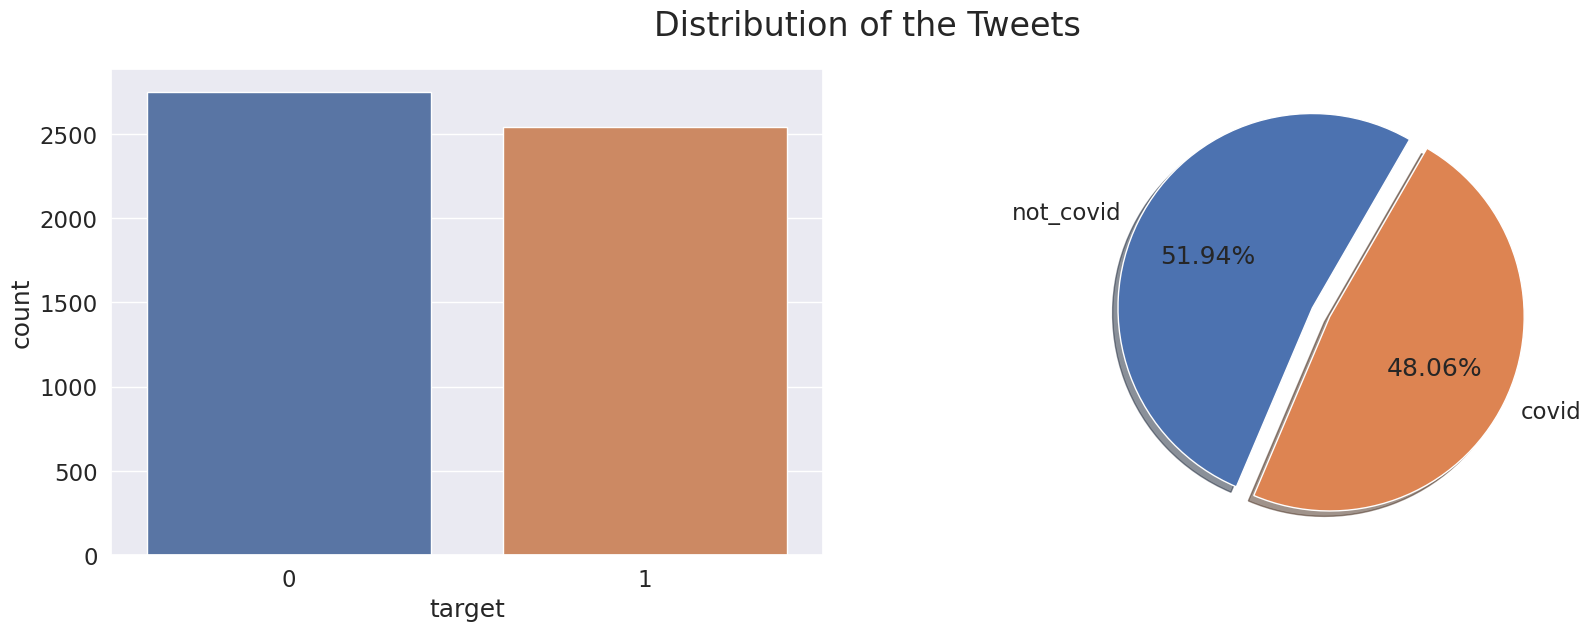

In [ ]:


# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['not_covid', 'covid'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0.05),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()



#### Tweet Lengths

In [ ]:
train.head()

,ID,text,target,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]","[bitcoin, halving, cancelled, due]","[(bitcoin, NN), (halving, VBG), (cancelled, VB...","[(bitcoin, n), (halving, v), (cancelled, v), (...","[bitcoin, halve, cancel, due]",bitcoin halve cancel due
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i...","[mercyofallah, good, times, wrapped, granular,...","[(mercyofallah, RB), (good, JJ), (times, NNS),...","[(mercyofallah, r), (good, a), (times, n), (wr...","[mercyofallah, good, time, wrap, granular, det...",mercyofallah good time wrap granular detail ch...
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of...","[266, days, digital, india, murder, e, learnin...","[(266, CD), (days, NNS), (digital, JJ), (india...","[(266, n), (days, n), (digital, a), (india, a)...","[266, day, digital, india, murder, e, learn, 2...",266 day digital india murder e learn 2g online...
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem...","[india, likely, run, remaining, rna, kits, ess...","[(india, RB), (likely, JJ), (run, NN), (remain...","[(india, r), (likely, a), (run, n), (remaining...","[india, likely, run, remain, rna, kit, essenti...",india likely run remain rna kit essential test...
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ...","[tough, times, best, way, grow, learn, case, t...","[(tough, JJ), (times, NNS), (best, JJS), (way,...","[(tough, a), (times, n), (best, a), (way, n), ...","[tough, time, best, way, grow, learn, case, te...",tough time best way grow learn case teach help...


In [ ]:
# Creating a new feature for the visualization.

train['Character Count'] = train['text'].apply(lambda x: len(str(x)))


def plot_dist3(df, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(18, 8))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='#e74c3c')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical CDF')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='#e74c3c')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='#e74c3c')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

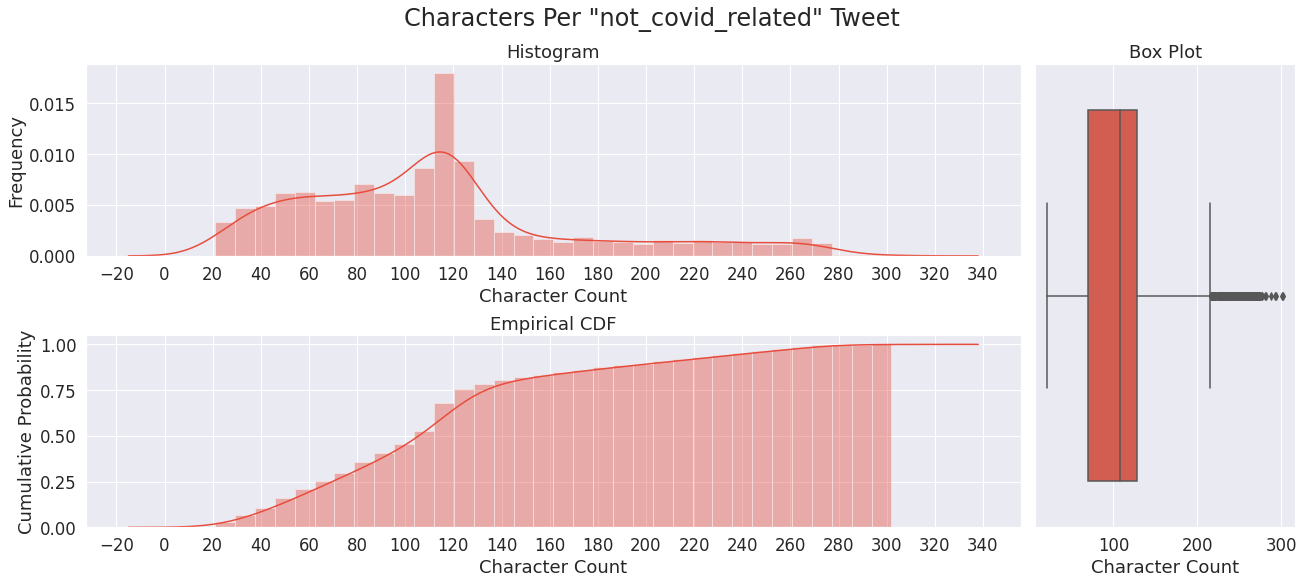

In [ ]:
plot_dist3(train[train['target'] == 0], 'Character Count',
           'Characters Per "not_covid_related" Tweet')

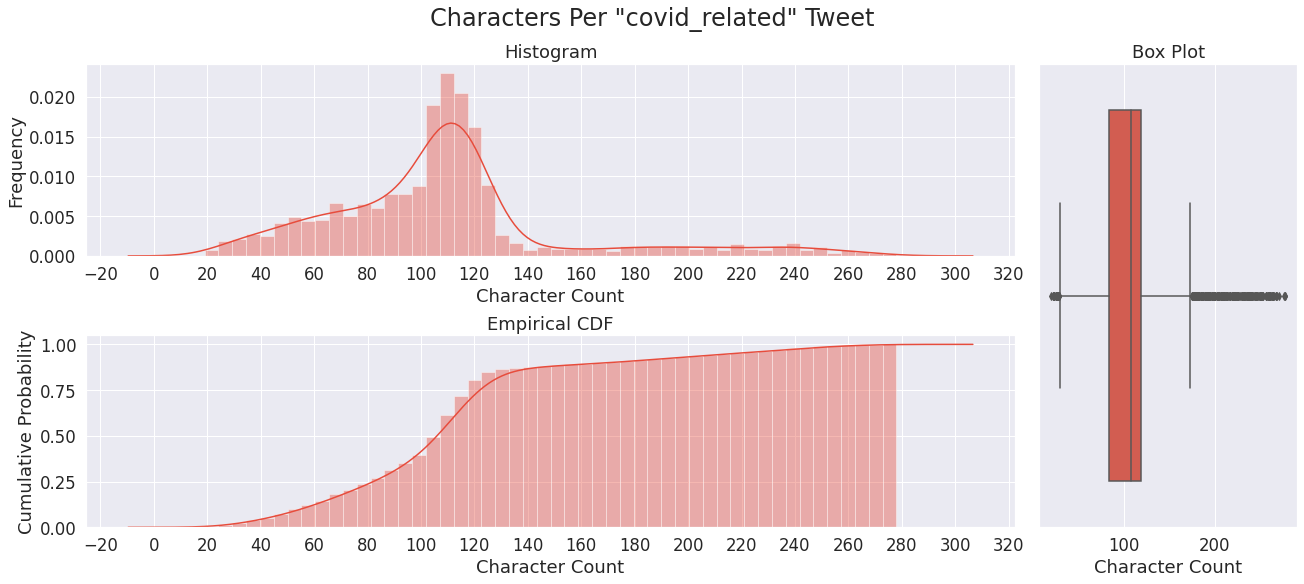

In [ ]:
plot_dist3(train[train['target'] == 1], 'Character Count',
           'Characters Per "covid_related" Tweet')

#### Word Count

In [ ]:
def plot_word_number_histogram(textno, textye):
    
    """A function for comparing word counts"""

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
    sns.distplot(textno.str.split().map(lambda x: len(x)), ax=axes[0], color='#e74c3c')
    sns.distplot(textye.str.split().map(lambda x: len(x)), ax=axes[1], color='#e74c3c')
    # sns.distplot(textun.str.split().map(lambda x: len(x)), ax=axes[2], color='#e74c3c')
    
    axes[0].set_xlabel('Word Count')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Not_covid related')
    axes[1].set_xlabel('Word Count')
    axes[1].set_title('covid_related')
    # axes[2].set_xlabel('Word Count')
    # axes[2].set_title('-1')
    
    fig.suptitle('Words Per Tweet', fontsize=24, va='baseline')
    
    fig.tight_layout()

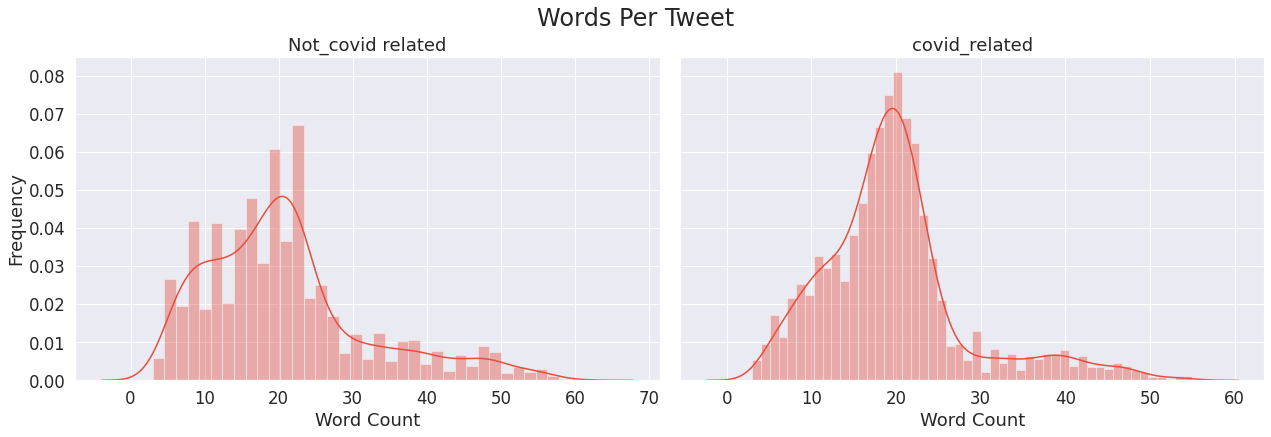

In [ ]:
plot_word_number_histogram(train[train['target'] == 0]['text'],
                           train[train['target'] == 1]['text'],
                           )

#### Word length

In [ ]:
def plot_word_len_histogram(textno, textye):

  ''' arguments represent the number of classes present. This function is used to calculate average word lengths'''
  
  fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), sharey=True)
  sns.distplot(textno.str.split().apply(lambda x: [len(i) for i in x]).map(
      lambda x: np.mean(x)),
                ax=axes[0], color='#e74c3c')
  sns.distplot(textye.str.split().apply(lambda x: [len(i) for i in x]).map(
      lambda x: np.mean(x)),
                ax=axes[1], color='#e74c3c')
  # sns.distplot(textna.str.split().apply(lambda x: [len(i) for i in x]).map(
  #     lambda x: np.mean(x)),
  #              ax=axes[2], color='#e74c3c')
  
  axes[0].set_xlabel('Word Length')
  axes[0].set_ylabel('Frequency')

  axes[0].set_title('Not_covid related')
  axes[1].set_xlabel('Word Length')
  axes[1].set_title('Covid related')
  # axes[2].set_xlabel('Word Length')
  # axes[2].set_title('-1')
  
  fig.suptitle('Mean Word Lengths', fontsize=24, va='baseline')
  fig.tight_layout()

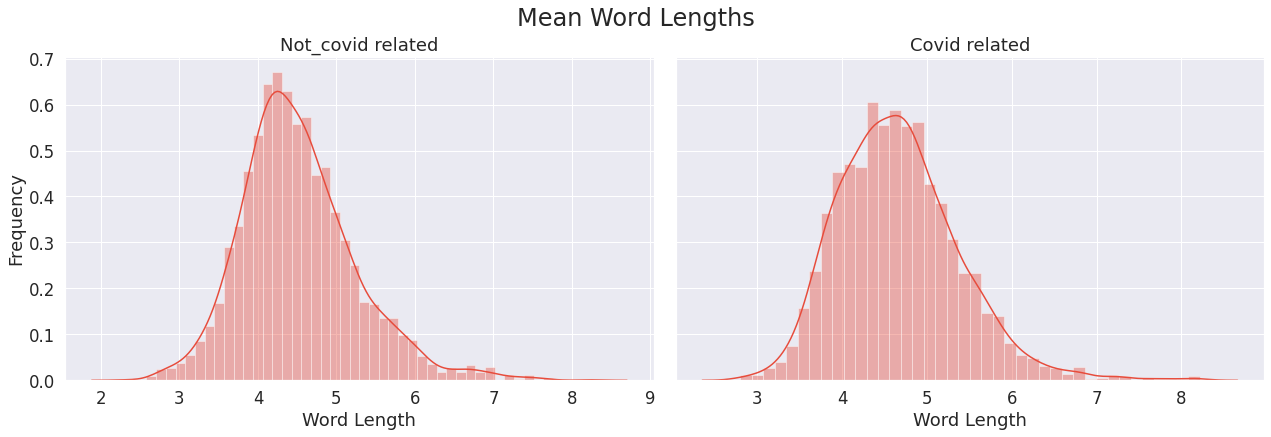

In [ ]:
plot_word_len_histogram(train[train['target'] == 0]['text'],
                           train[train['target'] == 1]['text'],)

#### Most Common Words

In [ ]:
train.head()

,ID,text,target,tokenized,lower,stops_removed,pos_tags,wordnet_pos,lemmatized,lemma_str,Character Count
0,train_0,The bitcoin halving is cancelled due to,1,"[The, bitcoin, halving, is, cancelled, due, to]","[the, bitcoin, halving, is, cancelled, due, to]","[bitcoin, halving, cancelled, due]","[(bitcoin, NN), (halving, VBG), (cancelled, VB...","[(bitcoin, n), (halving, v), (cancelled, v), (...","[bitcoin, halve, cancel, due]",bitcoin halve cancel due,39
1,train_1,MercyOfAllah In good times wrapped in its gran...,0,"[MercyOfAllah, In, good, times, wrapped, in, i...","[mercyofallah, in, good, times, wrapped, in, i...","[mercyofallah, good, times, wrapped, granular,...","[(mercyofallah, RB), (good, JJ), (times, NNS),...","[(mercyofallah, r), (good, a), (times, n), (wr...","[mercyofallah, good, time, wrap, granular, det...",mercyofallah good time wrap granular detail ch...,117
2,train_2,266 Days No Digital India No Murder of e learn...,1,"[266, Days, No, Digital, India, No, Murder, of...","[266, days, no, digital, india, no, murder, of...","[266, days, digital, india, murder, e, learnin...","[(266, CD), (days, NNS), (digital, JJ), (india...","[(266, n), (days, n), (digital, a), (india, a)...","[266, day, digital, india, murder, e, learn, 2...",266 day digital india murder e learn 2g online...,93
3,train_3,India is likely to run out of the remaining RN...,1,"[India, is, likely, to, run, out, of, the, rem...","[india, is, likely, to, run, out, of, the, rem...","[india, likely, run, remaining, rna, kits, ess...","[(india, RB), (likely, JJ), (run, NN), (remain...","[(india, r), (likely, a), (run, n), (remaining...","[india, likely, run, remain, rna, kit, essenti...",india likely run remain rna kit essential test...,112
4,train_4,In these tough times the best way to grow is t...,0,"[In, these, tough, times, the, best, way, to, ...","[in, these, tough, times, the, best, way, to, ...","[tough, times, best, way, grow, learn, case, t...","[(tough, JJ), (times, NNS), (best, JJS), (way,...","[(tough, a), (times, n), (best, a), (way, n), ...","[tough, time, best, way, grow, learn, case, te...",tough time best way grow learn case teach help...,121


In [ ]:
lis = [
train[train['target'] == 0]['lemma_str'],
train[train['target'] == 1]['lemma_str'],
# train[train['target'] == -1]['lemma_str']
]


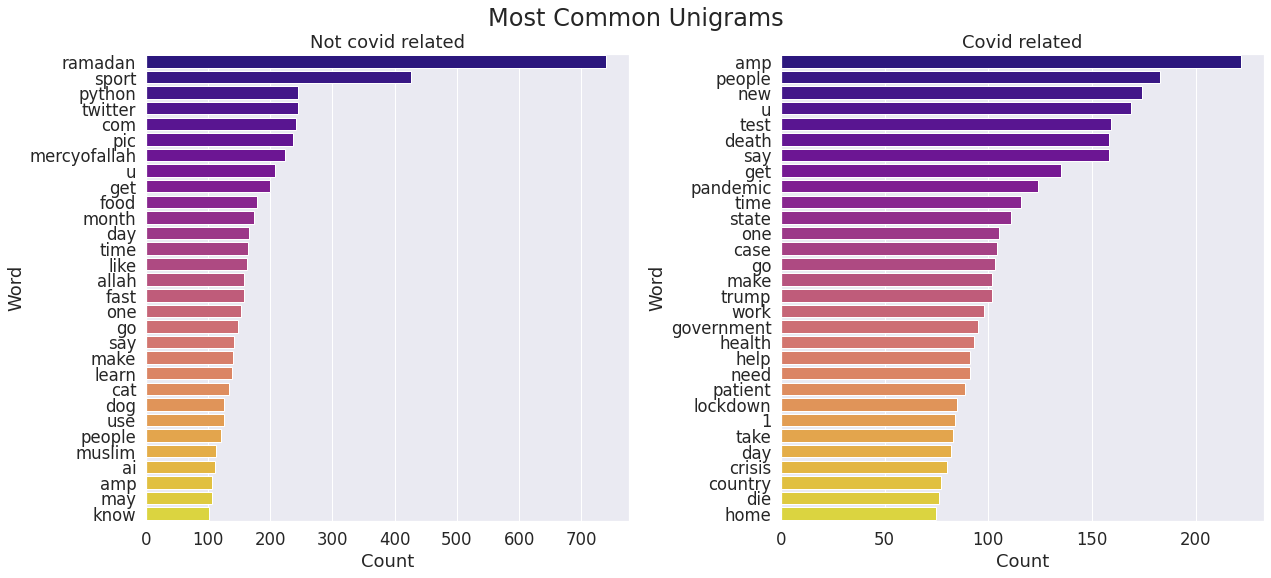

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()

for i, j in zip(lis, axes):

    new = i.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word, count in most[:30]:
        if (word not in stop):
            x.append(word)
            y.append(count)

    sns.barplot(x=y, y=x, palette='plasma', ax=j)
axes[0].set_title('Not covid related')
axes[1].set_title('Covid related')
# axes[2].set_title('Label -1')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Word')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Word')
# axes[2].set_xlabel('Count')
# axes[2].set_ylabel('Word')

fig.suptitle('Most Common Unigrams', fontsize=24, va='baseline')
plt.tight_layout()

#### Most Common Bigrams

In [ ]:
def ngrams(n, title):
    """A Function to plot most common ngrams"""
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    axes = axes.flatten()
    for i, j in zip(lis, axes):

        new = i.str.split()
        new = new.values.tolist()
        corpus = [word for i in new for word in i]

        def _get_top_ngram(corpus, n=None):
            #getting top ngrams
            vec = CountVectorizer(ngram_range=(n, n),
                                  max_df=0.9,
                                  stop_words='english').fit(corpus)
            bag_of_words = vec.transform(corpus)
            sum_words = bag_of_words.sum(axis=0)
            words_freq = [(word, sum_words[0, idx])
            for word, idx in vec.vocabulary_.items()]
            words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
            return words_freq[:15]

        top_n_bigrams = _get_top_ngram(i, n)[:15]
        x, y = map(list, zip(*top_n_bigrams))
        sns.barplot(x=y, y=x, palette='plasma', ax=j)
        
        axes[0].set_title('Not covid related')
        axes[1].set_title('Covid related')
        # axes[2].set_title('Label -1')
        axes[0].set_xlabel('Count')
        axes[0].set_ylabel('Words')
        axes[1].set_xlabel('Count')
        axes[1].set_ylabel('Words')
        # axes[2].set_xlabel('Count')
        # axes[2].set_ylabel('Words')
        fig.suptitle(title, fontsize=24, va='baseline')
        plt.tight_layout()

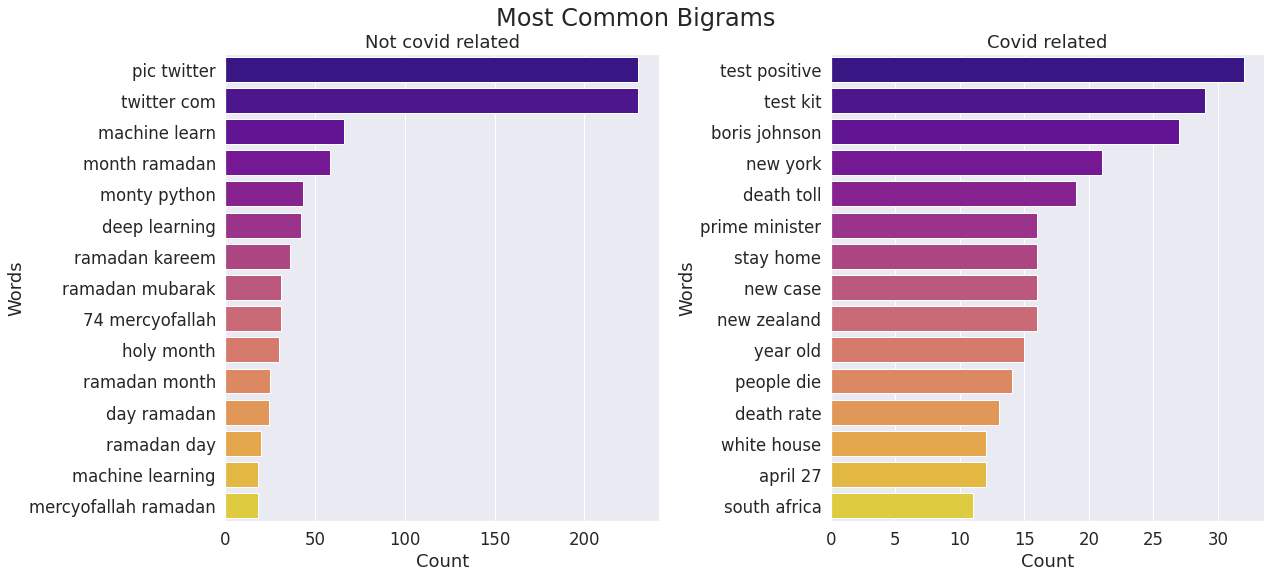

In [ ]:
ngrams(2, 'Most Common Bigrams')

### Most comming trigrams

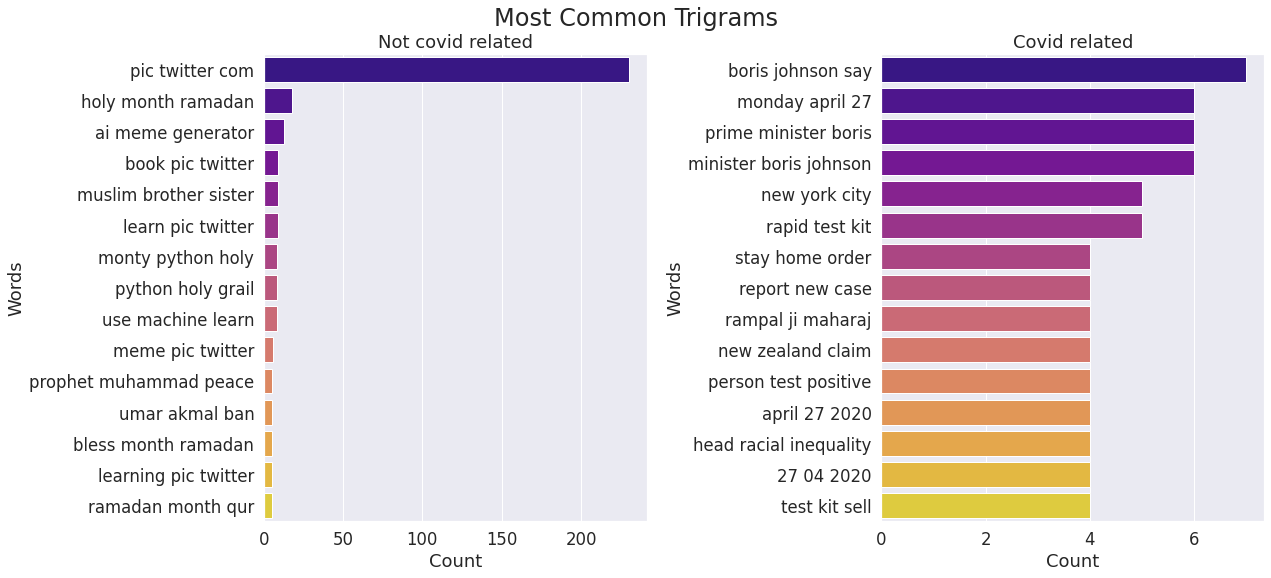

In [ ]:
ngrams(3, 'Most Common Trigrams')

### Word Cloud

In [ ]:
from google.colab import files
uploaded = files.upload()

mask = np.array(Image.open('twitter.jpeg'))
mask[mask.sum(axis=2) == 0] = 128

Saving twitter.jpeg to twitter.jpeg


In [ ]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1200,
        height=800,
        background_color='black',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='grey',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()


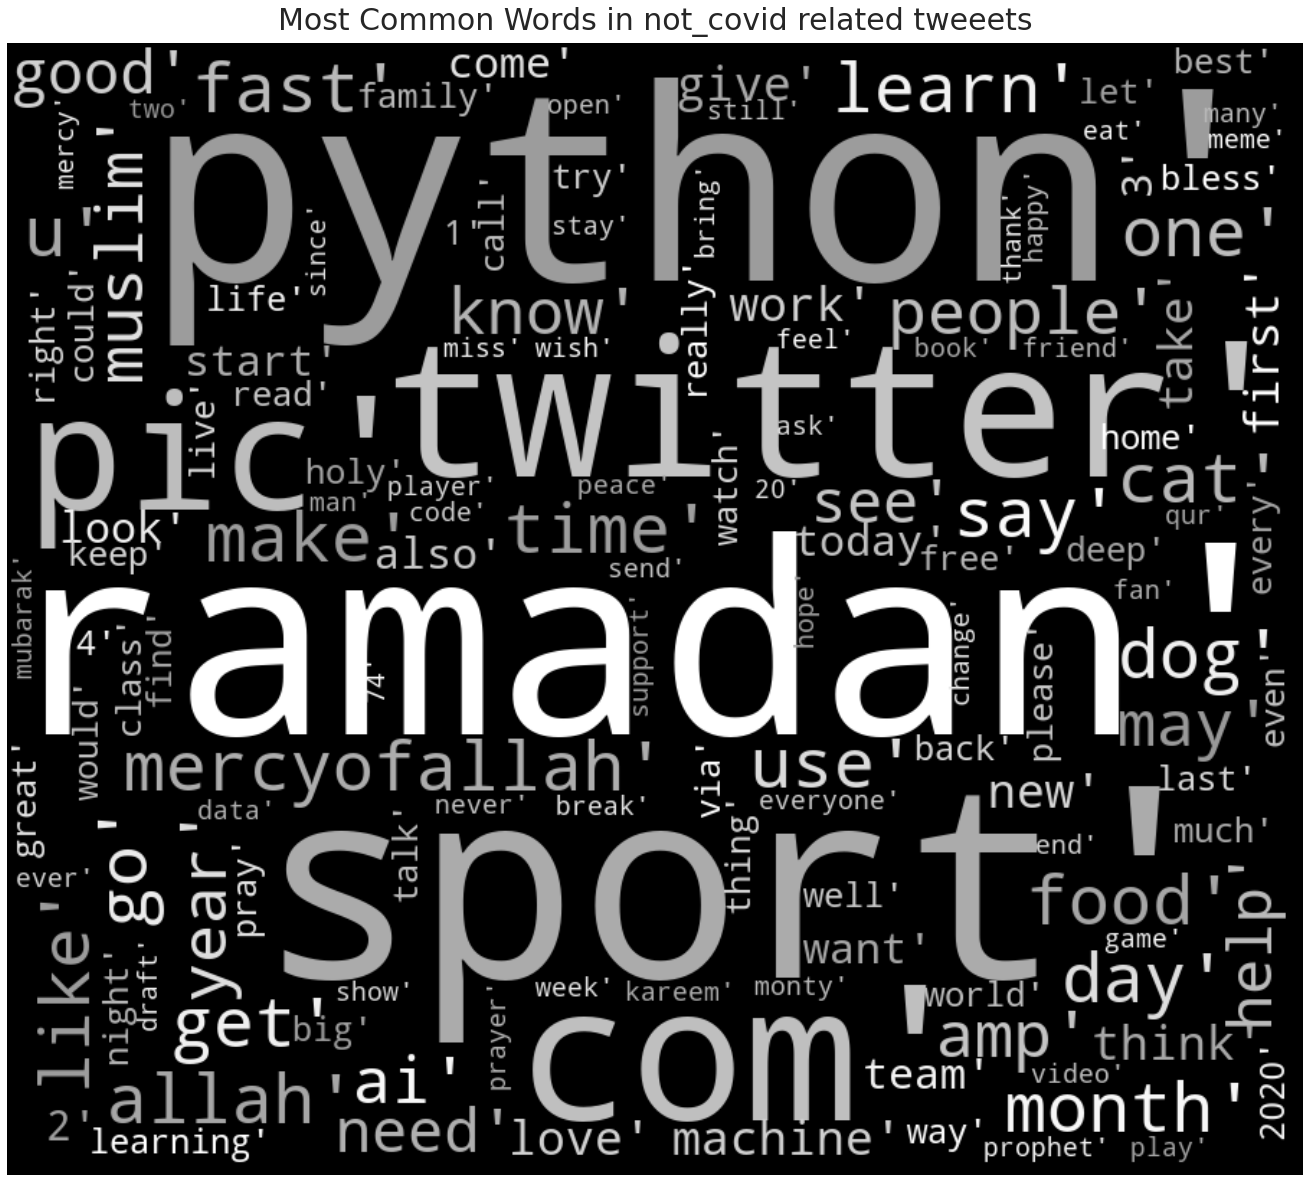

In [ ]:


plot_wordcloud(train[train['target'] == 0]['lemmatized'],
               'Most Common Words in not_covid related tweeets',
               title_size=30)



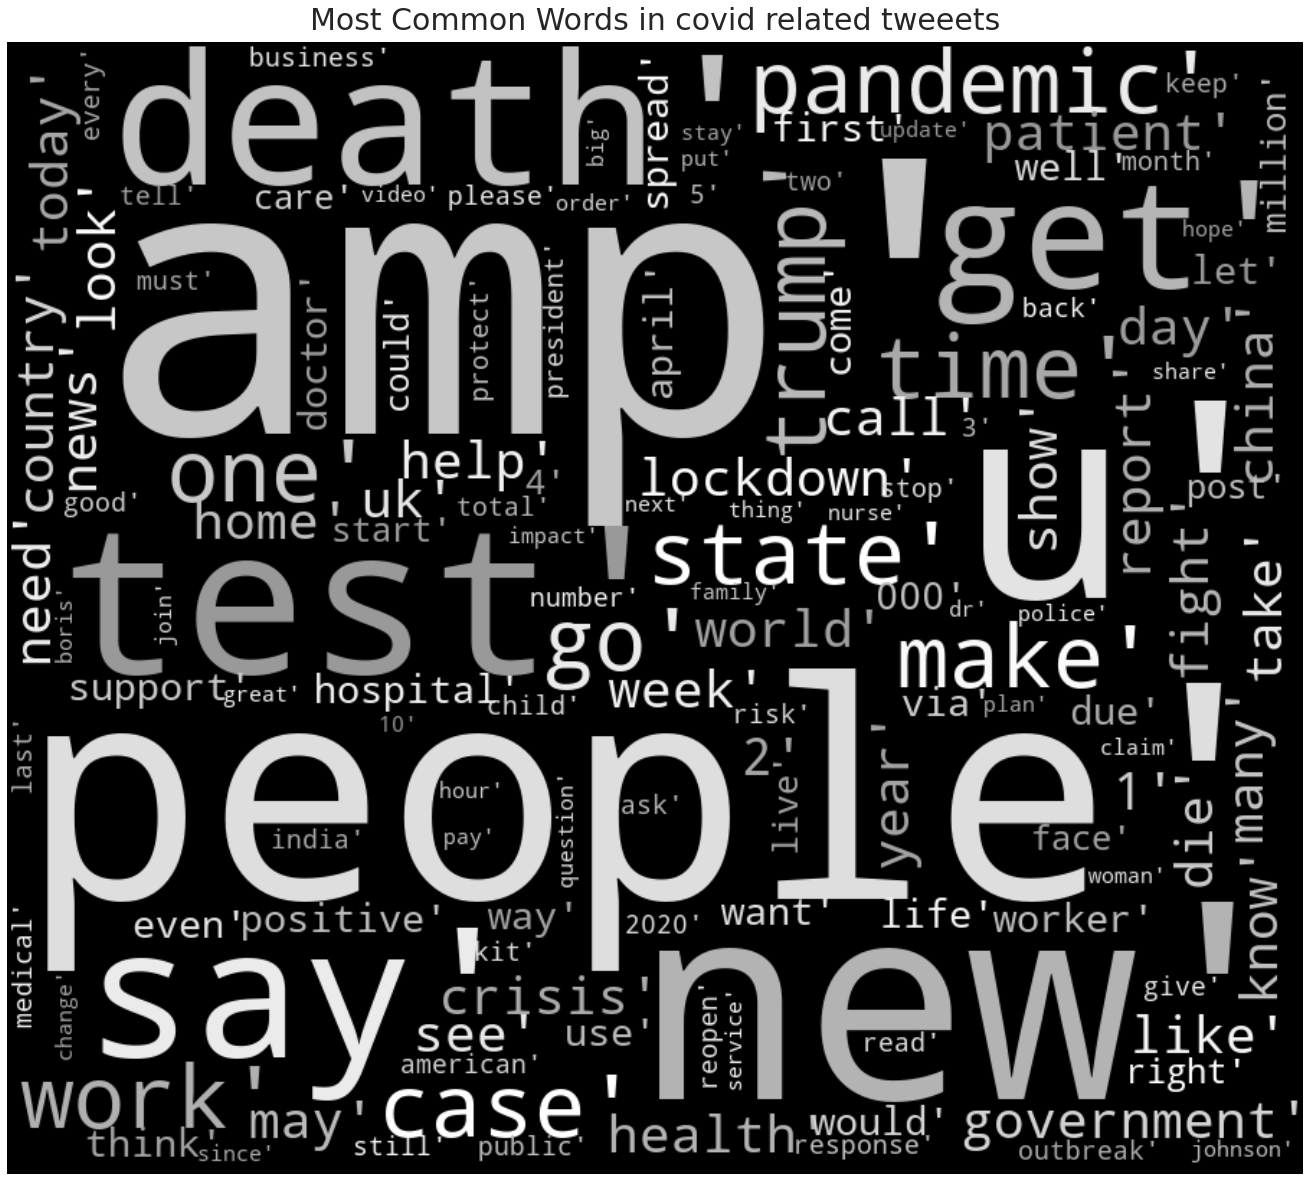

In [ ]:


plot_wordcloud(train[train['target'] == 1]['lemmatized'],
               'Most Common Words in covid related tweeets',
               title_size=30)



In [ ]:


# plot_wordcloud(train[train['target'] == -1]['lemmatized'],
#                'Most Common Words in label -1',
#                title_size=30)



#### Named Entity Recognition

In [ ]:
# Loading NER.
nlp = en_core_web_sm.load() 

In [ ]:
def plot_named_entity_barchart(text):
    
    """A function for extracting named entities and comparing them"""
    
    def _get_ner(text):
        doc = nlp(text)
        return [X.label_ for X in doc.ents]

    ent = text.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x)

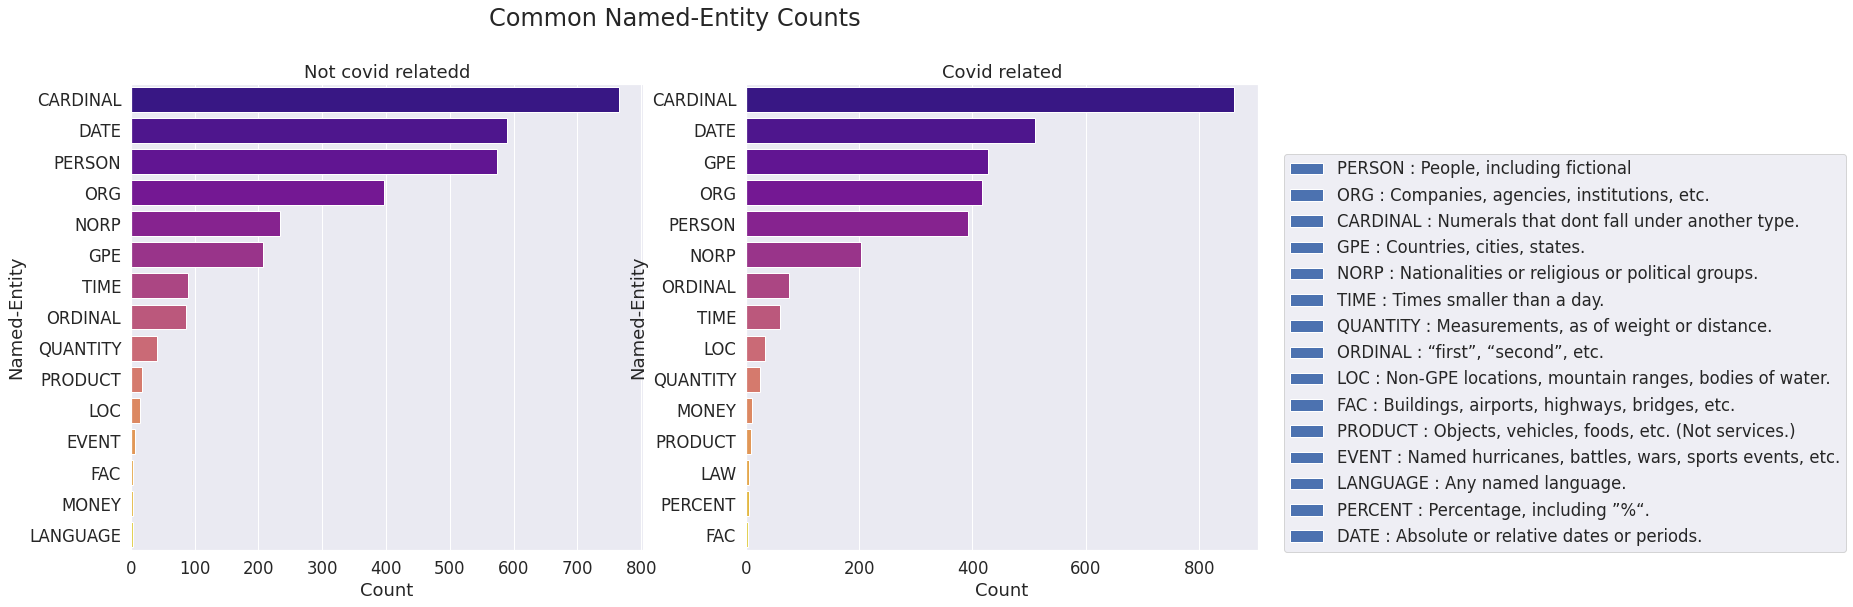

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
axes = axes.flatten()
for i, j in zip(lis, axes):

    def _get_ner(i):
        doc = nlp(i)
        return [X.label_ for X in doc.ents]

    ent = i.apply(lambda x: _get_ner(x))
    ent = [x for sub in ent for x in sub]
    counter = Counter(ent)
    count = counter.most_common()[:15]

    x, y = map(list, zip(*count))
    sns.barplot(x=y, y=x, ax=j, palette='plasma')

axes[0].set_title('Not covid relatedd')
axes[1].set_title('Covid related')
# axes[2].set_title('Label 2')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Named-Entity')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Named-Entity')
# axes[2].set_xlabel('Count')
# axes[2].set_ylabel('Named-Entity')
fig.suptitle('Common Named-Entity Counts', fontsize=24, va='baseline')



patch1 = mpatches.Patch(label='PERSON : People, including fictional')
patch2 = mpatches.Patch(label='ORG : Companies, agencies, institutions, etc.')
patch3 = mpatches.Patch(label='CARDINAL : Numerals that dont fall under another type.')
patch4 = mpatches.Patch(label='GPE : Countries, cities, states.')
patch5 = mpatches.Patch(label='NORP : Nationalities or religious or political groups.')
patch6 = mpatches.Patch(label='TIME : Times smaller than a day.')
patch7 = mpatches.Patch(label='QUANTITY : Measurements, as of weight or distance.')
patch8 = mpatches.Patch(label='ORDINAL : “first”, “second”, etc.')
patch9 = mpatches.Patch(label='LOC : Non-GPE locations, mountain ranges, bodies of water.')
patch10 = mpatches.Patch(label='FAC : Buildings, airports, highways, bridges, etc.')
patch11 = mpatches.Patch(label='PRODUCT : Objects, vehicles, foods, etc. (Not services.)')
patch12 = mpatches.Patch(label='EVENT : Named hurricanes, battles, wars, sports events, etc.')
patch13 = mpatches.Patch(label='LANGUAGE : Any named language.')
patch14 = mpatches.Patch(label='PERCENT : Percentage, including ”%“.')
patch15 = mpatches.Patch(label='DATE : Absolute or relative dates or periods.')



plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7, patch8, patch9, patch10, patch11, patch12, patch13, patch14, patch15, ],bbox_to_anchor=(1.05, 0.85), loc='upper left', borderaxespad=0.)

plt.show()

### Building the BERT Model